# Reinforcement Learning
Prof. Milica Gašić

### Multi-step double DQN

PyTorch needs to be installed for this notebook.

In [165]:
import collections
import copy
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch import nn, optim
from IPython.display import clear_output

import rl_gui
import rl_tests

#### Short PyTorch intro

In this notebook we will use the PyTorch library to implement deep Q-networks.  
The main advantages of PyTorch over NumPy are fast parallel computing on GPUs and automatic differentiation, i.e., gradients are computed for us automatically.

In this notebook we will not make use of a GPU, since the network is fairly small and computation on the CPU might even be faster.

PyTorch uses *tensors*, which are very similar to NumPy arrays, but they can be stored on a specific device (e.g., a GPU).  
The following code creates a tensor of shape `(8,3)`, i.e., a matrix in $\mathbb{R}^{8 \times 3}$, filled with zeros and stores it in the main memory:

In [166]:
x = torch.zeros((8, 3))
print(x)
print()
print(x.shape)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

torch.Size([8, 3])


For computational efficiency (and for more stable training), we will work with *batches* of data.  
For example, instead of updating the action value function for a single state, we update multiple states at once.  
E.g., if the *batch size* is 64, then the tensors for a single update might have the following shapes:
- `states`: `(64,5)`, i.e., the tensor contains 64 states and each state is a 5-dimensional vector
- `actions`: `(64)`, i.e., the tensor contains 64 actions
- `rewards`: `(64)`, i.e., the tensor contains 64 rewards

If tensors have the same batch size, we can work with them as if they are single values.  
E.g., if we have `rewards_0` with shape `(64)` and `rewards_1` with shape `(64)`, we can compute:  

`rewards_0 + gamma * rewards1`  

which will be a new tensor of shape `(64)`.

We already provide the code that takes care of automatic differentiation and optimization,  
so it should be sufficient if you understand the concept of tensors and batches.

### Deep Q-Networks (DQN)
  
As seen in the lecture, DQN learns an action-value function by minimizing the following mean squared error:
$$
\mathbb{E}_{s_t, a_t, r_{t+1}, s_{t+1}} [ (y_t - \hat{q}(s_t, a_t, w))^2 ],
$$
where $w$ are the parameters of the "online" network, $w^-$ are the parameters of the fixed target network, and
$y_t$ is the update target, which is defined as
$$
y_t = r_{t+1} + \gamma \max_a \hat{q}(s_{t+1}, a, w^-).
$$

**Double DQN:**  
The idea of double DQN (https://arxiv.org/abs/1509.06461) is to apply double Q-learning to the deep Q-network.  
The simplest way of doing this is to use the online network to select actions, but the fixed target network to compute the next action value.  
This leads to the update target
$$
y_t = r_{t+1} + \gamma \hat{q}(s_{t+1}, \arg\max_a \hat{q}(s_{t+1}, a, w), w^-).
$$

**Multi-step DQN:**  
The DQN can also be extended to $n$-step returns (https://arxiv.org/abs/1710.02298), which leads to the following update target:
$$
y_t = \sum_{k=0}^{n-1} \gamma^k r_{t+k+1} + \gamma^n \max_a \hat{q}(s_{t+n}, a, w^-)
$$

**Multi-step double DQN:**  
By combining both approaches we get the following update target, which we will use in this exercise:
$$
\sum_{k=0}^{n-1} \gamma^k r_{t+k+1} + \gamma^n \hat{q}(s_{t+n}, \arg\max_a \hat{q}(s_{t+n}, a, w), w^-)
$$

#### Replay Memory
DQN stores transitions in a replay memory. Batches of transitions are sampled from the memory and used to update the DQN.  
We have already implemented most of the replay memory below. Your task is to extend the functionality to sample multiple steps at once.

In [167]:
class ReplayMemory:

    def __init__(self, capacity, rng):
        # create a queue that removes old transitions when capacity is reached
        self.transitions = collections.deque([], maxlen=capacity)

        # random number generator used for sampling batches
        self.rng = rng

    def append(self, transition):
        # append a transition (a tuple) to the queue
        self.transitions.append(transition)

    def sample(self, batch_size, n_steps):
        # randomly sample a list of indices
        idx = self.rng.choice(len(self.transitions) - n_steps + 1, batch_size, replace=False)

        #######################################################################
        # TODO Modify the code to support multi-step sampling. The parameter  #
        # `n_steps` specifies how many steps should be sampled. The return    #
        # value `sequence` should be a list of batches for each time step.    #
        # This means that the result of the existing code below should be     #
        # stored in sequence[0], and you have to add the following steps to   #
        # the list (with the start indices from `idx`, but with an offset).   #
        #######################################################################
        # select the transitions using the indices
        sequence = []
        for j in range(n_steps):
            transitions = [self.transitions[i + j] for i in idx]

        # convert the list of transitions into multiple batches, one for each modality (states, actions, rewards, ...), i.e.
        # transitions: (s_1, a_1, r_1, ...), ..., (s_n, a_n, r_n, ...)
        # get converted into
        # batches: (s_1, ..., s_n), (a_1, ..., a_n), (r_1, ..., r_n), ...
        # they also get converted into PyTorch tensors
            batches = tuple(torch.as_tensor(np.array(batch)) for batch in zip(*transitions))
            sequence.append(batches)
        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        return sequence

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [168]:
def test_replay_memory():
    yield 'sample()'

    rng = np.random.Generator(np.random.PCG64(seed=42))
    memory = ReplayMemory(capacity=10, rng=rng)

    transitions = [
        (1, 2, 3),
        (4, 5, 6),
        (7, 8, 9),
        (10, 11, 12),
        (13, 14, 15),
        (16, 17, 18)
    ]

    for transition in transitions:
        memory.append(transition)

    test_data = [
        (4, 3, {(0, 0): [1, 4, 7], (1, 2): [11, 14, 17], (2, 3): [6, 9, 12]}),
        (2, 2, {(0, 1): [1, 4], (2, 0): [12, 15]})
    ]

    for batch_size, n_steps, samples in test_data:
        sequence = memory.sample(batch_size, n_steps)
        yield isinstance(sequence, (tuple, list)), 'sequence must be a tuple or list'
        yield len(sequence) == n_steps, 'Length of sequence is incorrect'

        for batches in sequence:
            yield isinstance(batches, (tuple, list)), 'Each value of sequence must be a tuple or list (containing the batches)'
            for batch in batches:
                yield torch.is_tensor(batch), 'Each batch must be a tensor'
                yield batch.shape[0] == batch_size, 'Batch size is incorrect'

        for (modality, index), values in samples.items():
            for step in range(n_steps):
                yield sequence[step][modality][index] == values[step], 'Tensor contains incorrect value'

        yield None


rl_tests.run_tests(test_replay_memory())

Testing sample()...
2/2 tests passed!


#### Deep Q-network

The class `MultiStepDDQN` is a subclass of `torch.nn.Module`, which takes care of the automatic differentiation.  
Your task is to finish the implementation of `compute_q()`, `compute_max_q()` and `compute_loss()`:

In [169]:
class MultiStepDDQN(nn.Module):

    def __init__(self, state_dim, num_actions):
        super().__init__()
        # create a simple neural network with two fully-connected layers
        # and a ReLU nonlinearity
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )

    def compute_q(self, states, actions):
        # states has shape (batch_size, state_dim)
        # actions has shape (batch_size)

        # compute q[s], which has shape (batch_size, num_actions)
        q_all = self.network(states)

        ########################################################################
        # TODO Implement the computation of q(s,a), given states and actions   #
        # using self.network. The neural network takes as input a batch of     #
        # states and produces a tensor of size (batch_size, num_actions)       #
        # HINT: You can use the function torch.gather with inputs              #
        # q_all and actions                                                    #
        ########################################################################

        # select q[s,a], which has shape (batch_size); use torch.gather
        q = torch.gather(q_all, 1, actions.unsqueeze(1))

        ########################################################################
        # End of your code.                                                    #
        ########################################################################

        return q

    def compute_max_q(self, states):
        # states has shape (batch_size, state_dim)

        # compute q[s], which has shape (batch_size, num_actions)
        q_all = self.network(states)

        ########################################################################
        # TODO Implement the computation of max_a' q(s,a'), given states       #
        # using self.network. The neural network takes as input a batch of     #
        # states and produces a tensor of size (batch_size, num_actions)       #
        ########################################################################

        # select max_a' q[s,a'], which has shape (batch_size)
        actions = self.compute_arg_max(states)
        max_q = self.compute_q(states, actions)

        ########################################################################
        # End of your code.                                                    #
        ########################################################################

        return max_q

    def compute_arg_max(self, states):
        # states has shape (batch_size, state_dim)

        # compute q[s], which has shape (batch_size, num_actions)
        q_all = self.network(states)

        # select argmax_a' q[s,a'], which has shape (batch_size)
        actions = q_all.argmax(dim=1)
        return actions

    def compute_loss(self, target_dqn, sequence, gamma):
        # sequence contains a list of batches from the replay memory

        # the number of steps is the length of the sequence
        n_steps = len(sequence)

        # sequence[0] contains the states and actions that should be updated
        states_0, actions_0, rewards_0, terminations_0, next_states_0 = sequence[0]

        # sequence[n_steps - 1] contains the next states that are used for bootstrapping
        states_n, actions_n, rewards_n, terminations_n, next_states_n = sequence[n_steps - 1]

        # turn off gradient computation
        with torch.no_grad():
            #######################################################################
            # TODO Implement the multi-step DDQN targets as described above.      #
            # You can see how we obtained the batches for the first and last time #
            # step above. You need to do the same for all n steps in order to     #
            # calculate the targets.                                              #
            #                                                                     #
            # Hint #1: The implementation for the normal 1-step DQN (without      #
            # double Q-learning) would look like this:                            #
            # max_q = target_dqn.compute_max_q(next_states_n)                     #
            # targets = rewards_0 + gamma * (~terminations) * max_q               #
            # Hint #2: Iterate backwards.                                         #
            #######################################################################

            actions_max = self.compute_arg_max(next_states_n)
            max_q = target_dqn.compute_q(next_states_n, actions_max)
            targets = (~terminations_n) * max_q * gamma ** n_steps

            for k in (range(n_steps)):
                states_k, actions_k, rewards_k, terminations_k, next_states_k =\
                    sequence[k]
                targets += gamma ** k * rewards_k * (~terminations_k)


            #######################################################################
            # End of your code.                                                   #
            #######################################################################

        # compute predictions q[s,a]
        q = self.compute_q(states_0, actions_0)

        # compute mean squared error between q[s,a] and targets
        loss = torch.mean((q - targets.detach()) ** 2)
        return loss

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [170]:
def test_multi_ddqn():
    yield 'compute_loss()'

    rng = np.random.Generator(np.random.PCG64(seed=42))
    state_dim = 5
    num_actions = 3
    ddqn = MultiStepDDQN(state_dim, num_actions)
    with torch.no_grad():
        layer1, layer2 = ddqn.network[0], ddqn.network[2]
        layer1.weight[:] = torch.as_tensor(rng.normal(0, 0.01, layer1.weight.shape))
        layer2.weight[:] = torch.as_tensor(rng.normal(0, 0.01, layer2.weight.shape))
        nn.init.zeros_(layer1.bias)
        nn.init.zeros_(layer2.bias)

    memory = ReplayMemory(20, rng)
    state = rng.standard_normal(state_dim, dtype=np.float32)
    for _ in range(100):
        action = rng.integers(num_actions)
        reward = rng.standard_normal(dtype=np.float32)
        terminated = rng.uniform(0.0, 1.0) < 0.2
        next_state = rng.standard_normal(state_dim, dtype=np.float32)
        memory.append((state, action, reward, terminated, next_state))
        if terminated:
            state = rng.standard_normal(state_dim, dtype=np.float32)
        else:
            state = next_state

    gamma = 0.8
    for batch_size, n_steps, expected_loss in [(6, 3, 2.01768165), (16, 0, 1.17322925), (2, 8, 2.35127176)]:
        sequence = memory.sample(batch_size=6, n_steps=3)
        loss = ddqn.compute_loss(ddqn, sequence, gamma).item()
        yield np.isclose(loss, expected_loss), f'Loss is incorrect (error = {abs(expected_loss - loss)})'

    yield None


rl_tests.run_tests(test_multi_ddqn())

Testing compute_loss()...
0/1 tests passed!
Test #1 failed:
Loss is incorrect (error = 0.2976400173477174)
Loss is incorrect (error = 0.4582302895050048)
Loss is incorrect (error = 0.37866271687866204)


### CartPole environment

We will evaluate the agent on the CartPole environment.  
You can read more about it here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/  
(we use the `-v0` version)

Define a function to create the environment:

In [171]:
def create_env(seed):
    env_id = f'CartPole-v0'
    env = gym.make(env_id, render_mode='rgb_array')
    env.reset(seed=seed)
    return env

Evaluate a random policy:

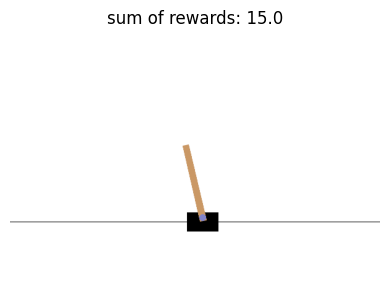

In [172]:
env = create_env(seed=42)
render = rl_gui.create_renderer(env, fps=60, figsize=(4, 3))

env.reset()
render()
reward_sum = 0.0
for _ in range(200):
    action = env.action_space.sample()
    _, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    render(f'sum of rewards: {reward_sum}')
    if terminated or truncated:
        break

### Training
We already implemented the training code below.  
The agent should reach a score of 200 at the end of training.

In [173]:
# initialize random number generators
seed = 1
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

num_steps = 30000        # number of steps in the environment
batch_size = 64          # number of transitions in a batch
replay_capacity = 1000   # number of transitions that are stored in memory
gamma = 0.99             # discount factor
n_steps = 3              # number of steps for multi-step target
learning_rate = 0.001    # learning rate
target_interval = 100    # synchronize the target network after this number of steps

# decrease the epsilon-greedy probability linearly
epsilon_start = 1.0     # start value
epsilon_end = 0.05      # end value
epsilon_steps = 5000    # number of steps to reach the end value

# create the environment and replay memory
env = create_env(seed)
memory = ReplayMemory(replay_capacity, rng)

# create the deep Q-network and optimizer
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n
dqn = MultiStepDDQN(state_dim, num_actions)
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)

# create the target Q-network
target_dqn = copy.deepcopy(dqn)

# store values for learning curves
loss_steps = []
loss_history = []
reward_steps = []
reward_history = []
episode_i = 0
reward_sum = 0.0

# main training loop
state, _ = env.reset(seed=seed)

for step in range(num_steps):
    update_plot = False

    # compute the epsilon-greedy probability
    epsilon = epsilon_start + (epsilon_end - epsilon_start) * min(step / epsilon_steps, 1.0)

    # select an action
    if rng.random() < epsilon:
        action = rng.choice(num_actions)
    else:
        dqn.eval()  # switch to evaluation mode
        # convert state to tensor, need to call unsqueeze(0) for a batch size of 1
        action = dqn.compute_arg_max(torch.as_tensor(state).unsqueeze(0)).item()

    # execute the action
    next_state, reward, terminated, truncated, _ = env.step(action)

    # convert reward to float32 (should be faster)
    reward = np.float32(reward)

    # add the transition to replay memory
    transition = (state, action, reward, terminated, next_state)
    memory.append(transition)
    reward_sum += reward

    if terminated or truncated:
        reward_steps.append(episode_i)
        reward_history.append(reward_sum)
        episode_i += 1
        state, _ = env.reset()
        reward_sum = 0.0
        update_plot = True
    else:
        state = next_state

    # check if enough transitions in replay memory
    if step >= batch_size + n_steps:
        # sample a batch of transitions from the replay memory
        sequence = memory.sample(batch_size, n_steps)
        # minimize the loss function using SGD
        dqn.train()  # switch to training mode
        loss = dqn.compute_loss(target_dqn, sequence, gamma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            loss_steps.append(step)
            loss_history.append(loss.item())
            update_plot = True

    # synchronize the target network if necessary
    if step > 0 and step % target_interval == 0:
        target_dqn = copy.deepcopy(dqn)

    # plot curves for the loss and sum of rewards
    if update_plot:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes[0].set_xlabel('step')
        axes[0].set_ylabel('loss')
        axes[0].plot(loss_steps, loss_history)
        axes[1].set_xlabel('episode')
        axes[1].set_ylabel('sum of rewards')
        axes[1].plot(reward_steps, reward_history)
        plt.subplots_adjust(wspace=0.2)
        plt.show()
        plt.close()

KeyboardInterrupt: 

Now we can evaluate the trained agent:

In [ ]:
render = rl_gui.create_renderer(env, fps=60, figsize=(4, 3))

with torch.no_grad():
    dqn.eval()
    state, _ = env.reset()
    render()
    reward_sum = 0.0

    while True:
        state = torch.as_tensor(state).unsqueeze(0)
        action = dqn.compute_arg_max(state).item()
        state, reward, terminated, truncated, _ = env.step(action)
        reward_sum += reward
        render(f'action: {action}, sum of rewards: {reward_sum:.2f}')
        if terminated or truncated:
            break